In [0]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from tqdm import tqdm

In [0]:
device = torch.device("cuda:0" if torch.cuda.torch.cuda.is_available() else "cpu")

In [16]:
# 데이터 셋을 받을 때 transform할 조건을 설정합니다.

# Train data를 위한 transform
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                               ])
 

# Validation data를 위한 transform
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(), # 데이터를 불러 올 때 Tensor 타입으로 불러옵니다.
                               transforms.Normalize((0.5,), (0.5,)) # 앞의 괄호는 평균, 뒤의 괄호는 표준편차
                               ])

training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
 
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## NumPy Image Conversion Function

In [0]:
def im_convert(tensor):
    image = tensor.clone().to("cpu").detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

## Defining Classes

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  

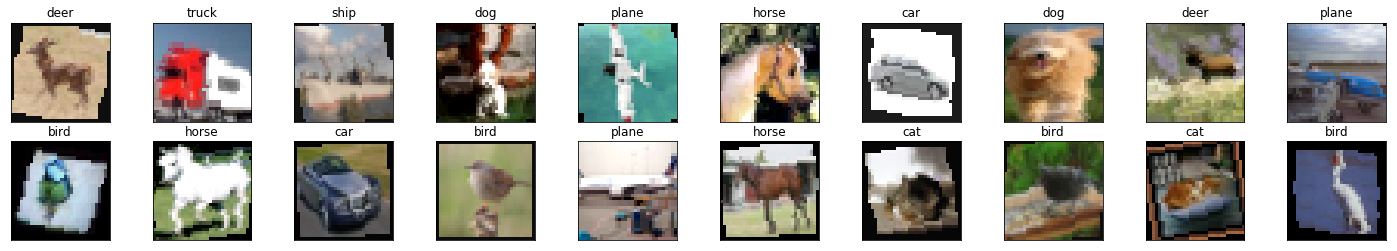

In [231]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [20]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
print(images.shape)

torch.Size([100, 3, 32, 32])


In [21]:
x = F.relu(nn.Conv2d(3, 20, 5)(images))
x = F.max_pool2d(x, 2, 2)
print(x.shape)
x = F.relu(nn.Conv2d(20, 50, 5)(x))
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([100, 20, 14, 14])
torch.Size([100, 50, 5, 5])


## Model Class Constructor

In [0]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # (입력 채널, 출력 채널, 필터 크기)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(2*2*128, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm1d(1024)
        self.bn6 = nn.BatchNorm1d(512)
        self.bn7 = nn.BatchNorm1d(256)
        
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2, 2)        
        x = x.view(-1, 2*2*128)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn6(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn7(self.fc3(x)))
        x = self.fc4(x)
        return x       

## Declaring Classifier

In [215]:
model = ConvNet().to(device)
print(model)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=10, bias=True)
  (dropout1): Dropout(p=0.3)
  (dropout2): Dropout(p=0.3)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1

In [216]:
model.forward(images.to(device)).shape

torch.Size([100, 10])

## Loss and Optimizer

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)

## Training Process

In [0]:
epochs = 30
# 학습 데이터의 loss를 저장
running_loss_history = []
# 학습 데이터의 accuracy를 저장
running_corrects_history = []
# 평가 데이터의 loss를 저장
val_running_loss_history = []
# 평가 데이터의 accuracy를 저장
val_running_corrects_history = []

In [220]:
for epoch in tqdm(range(epochs)):
    running_loss, val_running_loss = 0.0, 0.0
    running_corrects, val_running_corrects = 0.0, 0.0
    
    # 학습 데이터를 batch 단위로 가져와서 학습시킵니다.
    model.train()
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # feedforward
        outputs = model(inputs)
        # loss를 계산합니다.
        loss = loss_func(outputs, labels)
        # gradient 초기화
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        # weight update
        optimizer.step()
        
        # output의 각 이미지 별로 class가 가장 큰 값을 가져옵니다.
        _, preds = torch.max(outputs, 1)
        
        # loss를 더해줍니다.
        running_loss += loss.item()
        # 분류가 잘 된 갯수를 더해줍니다.
        running_corrects += torch.sum(preds == labels.data)
    
    # epoch의 loss를 계산합니다.
    epoch_loss = running_loss/len(training_loader)
    running_loss_history.append(epoch_loss)
    
    # epoch의 accuracy를 계산합니다.
    epoch_acc = running_corrects/len(training_loader)
    running_corrects_history.append(epoch_acc)
    
    # 평가 데이터를 feedforward할 때에는 gradient가 필요없습니다.
    model.eval()
    with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)            
            
            # training 과정과 유사하나 학습이 필요없으므로 backprob하고 weight 업데이트 하는 과정이 없습니다.
            val_outputs = model(val_inputs)
            val_loss = loss_func(val_outputs, val_labels)
            
            _, val_preds = torch.max(val_outputs, 1)
            
            val_running_loss += val_loss.item()
            val_running_corrects += torch.sum(val_preds==val_labels.data)
    
    # 평가 데이터의 loss와 accuracy를 저장해줍니다.
    val_epoch_loss = val_running_loss / len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    
    val_epoch_acc = val_running_corrects / len(validation_loader)
    val_running_corrects_history.append(val_epoch_acc)
    
    # 매 epoch의 학습과 평가가 끝났으면 결과를 출력해줍니다.
    print('training loss : {:4f}, acc : {:4f}, validation loss : {:4f}, acc : {:4f}'.format(
        epoch_loss, epoch_acc, val_epoch_loss, val_epoch_acc))





  0%|          | 0/30 [00:00<?, ?it/s]



  3%|▎         | 1/30 [00:33<16:06, 33.31s/it]

training loss : 1.467724, acc : 46.000000, validation loss : 1.120354, acc : 59.000000






  7%|▋         | 2/30 [01:06<15:30, 33.22s/it]

training loss : 1.167180, acc : 58.000000, validation loss : 1.001327, acc : 64.000000






 10%|█         | 3/30 [01:39<14:55, 33.17s/it]

training loss : 1.033772, acc : 63.000000, validation loss : 0.941033, acc : 66.000000






 13%|█▎        | 4/30 [02:12<14:19, 33.07s/it]

training loss : 0.954108, acc : 66.000000, validation loss : 0.853592, acc : 70.000000






 17%|█▋        | 5/30 [02:44<13:41, 32.88s/it]

training loss : 0.888368, acc : 68.000000, validation loss : 0.766056, acc : 72.000000






 20%|██        | 6/30 [03:18<13:13, 33.04s/it]

training loss : 0.841441, acc : 70.000000, validation loss : 0.720643, acc : 74.000000






 23%|██▎       | 7/30 [03:50<12:38, 32.97s/it]

training loss : 0.804693, acc : 71.000000, validation loss : 0.707320, acc : 75.000000






 27%|██▋       | 8/30 [04:23<12:03, 32.90s/it]

training loss : 0.780008, acc : 72.000000, validation loss : 0.687101, acc : 75.000000






 30%|███       | 9/30 [04:56<11:27, 32.76s/it]

training loss : 0.748661, acc : 73.000000, validation loss : 0.704878, acc : 75.000000






 33%|███▎      | 10/30 [05:28<10:55, 32.79s/it]

training loss : 0.730105, acc : 74.000000, validation loss : 0.650901, acc : 77.000000






 37%|███▋      | 11/30 [06:01<10:24, 32.86s/it]

training loss : 0.706068, acc : 75.000000, validation loss : 0.636484, acc : 77.000000






 40%|████      | 12/30 [06:34<09:51, 32.86s/it]

training loss : 0.688601, acc : 75.000000, validation loss : 0.617825, acc : 78.000000






 43%|████▎     | 13/30 [07:08<09:22, 33.08s/it]

training loss : 0.669390, acc : 76.000000, validation loss : 0.615288, acc : 78.000000






 47%|████▋     | 14/30 [07:41<08:48, 33.06s/it]

training loss : 0.662650, acc : 76.000000, validation loss : 0.604540, acc : 79.000000






 50%|█████     | 15/30 [08:14<08:16, 33.09s/it]

training loss : 0.640764, acc : 77.000000, validation loss : 0.607719, acc : 78.000000






 53%|█████▎    | 16/30 [08:47<07:43, 33.09s/it]

training loss : 0.629487, acc : 77.000000, validation loss : 0.588919, acc : 79.000000






 57%|█████▋    | 17/30 [09:20<07:07, 32.92s/it]

training loss : 0.620318, acc : 78.000000, validation loss : 0.576053, acc : 79.000000






 60%|██████    | 18/30 [09:53<06:34, 32.91s/it]

training loss : 0.605106, acc : 78.000000, validation loss : 0.571266, acc : 80.000000






 63%|██████▎   | 19/30 [10:25<06:01, 32.88s/it]

training loss : 0.589734, acc : 79.000000, validation loss : 0.572403, acc : 80.000000






 67%|██████▋   | 20/30 [10:58<05:28, 32.88s/it]

training loss : 0.580411, acc : 79.000000, validation loss : 0.562930, acc : 80.000000






 70%|███████   | 21/30 [11:32<04:57, 33.02s/it]

training loss : 0.572893, acc : 80.000000, validation loss : 0.563024, acc : 80.000000






 73%|███████▎  | 22/30 [12:05<04:25, 33.14s/it]

training loss : 0.567316, acc : 80.000000, validation loss : 0.547267, acc : 80.000000






 77%|███████▋  | 23/30 [12:38<03:52, 33.19s/it]

training loss : 0.560688, acc : 80.000000, validation loss : 0.567194, acc : 80.000000






 80%|████████  | 24/30 [13:11<03:18, 33.12s/it]

training loss : 0.550074, acc : 80.000000, validation loss : 0.550671, acc : 80.000000






 83%|████████▎ | 25/30 [13:44<02:45, 33.11s/it]

training loss : 0.542862, acc : 80.000000, validation loss : 0.538564, acc : 81.000000






 87%|████████▋ | 26/30 [14:17<02:11, 32.95s/it]

training loss : 0.531924, acc : 81.000000, validation loss : 0.546422, acc : 81.000000






 90%|█████████ | 27/30 [14:49<01:38, 32.80s/it]

training loss : 0.524035, acc : 81.000000, validation loss : 0.542978, acc : 81.000000






 93%|█████████▎| 28/30 [15:22<01:05, 32.83s/it]

training loss : 0.522119, acc : 81.000000, validation loss : 0.553358, acc : 81.000000






 97%|█████████▋| 29/30 [15:54<00:32, 32.64s/it]

training loss : 0.510621, acc : 81.000000, validation loss : 0.591654, acc : 80.000000






100%|██████████| 30/30 [16:27<00:00, 32.63s/it]





training loss : 0.498129, acc : 82.000000, validation loss : 0.540682, acc : 81.000000


## Plotting Training and Validation Loss

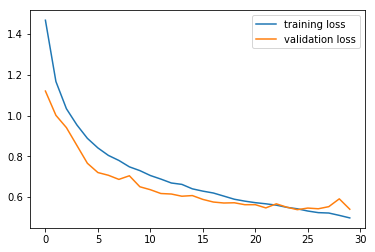

In [223]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

## Plotting Accuracy

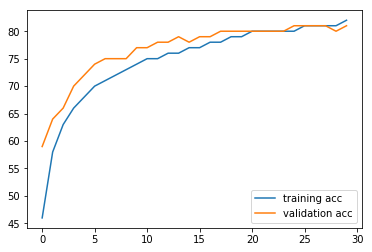

In [224]:
plt.plot(running_corrects_history, label='training acc')
plt.plot(val_running_corrects_history, label='validation acc')
plt.legend()

## Show Image

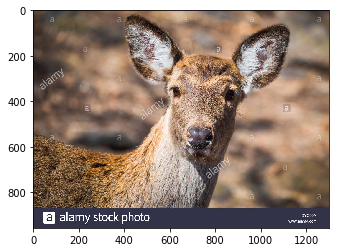

In [225]:
!pip3 install pillow==4.0.0
import requests
from PIL import Image
 
url = 'https://c8.alamy.com/comp/DYC06A/hornless-reindeer-at-zoo-DYC06A.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

## Preprocessing Image

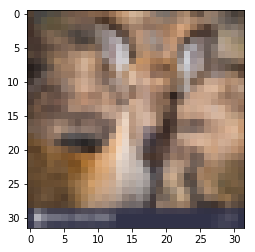

In [226]:
img = transform(img) 
plt.imshow(im_convert(img))

## Prediction

In [227]:
model.eval()
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

deer


## Validation Prediction

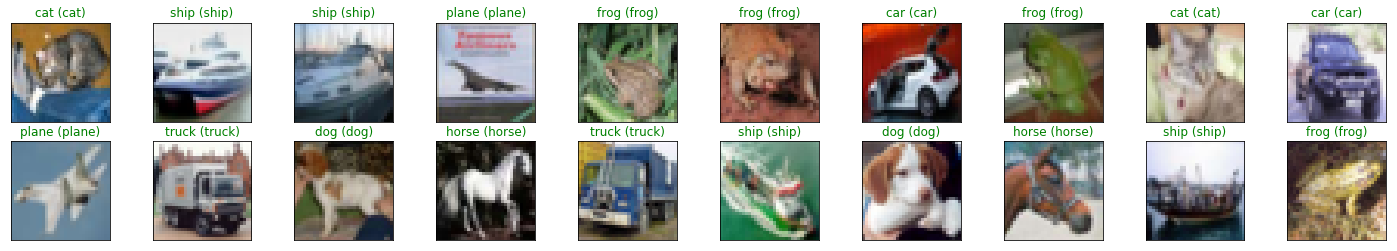

In [233]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))